# Demo For Concept-based Explanations for Semantic Segmentation Models

## Imports

In [2]:
import os
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from helpers import makedir
import model
import train_and_test as tnt
import save
import matplotlib.pyplot as plt
import numpy as np
from settings import *
from matplotlib.pyplot import show
import random
from models.model import UNetLightning

## Load the trained **Explainer** and **Segmentation** Models

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_workers = 4 if torch.cuda.is_available() else 0

protovae = model.ProtoVAE().to(device)

data_name = "colon"

# load model
protovae.load_state_dict(torch.load('saved_models/colon/model.pth',map_location=torch.device('cpu')),strict=False)
protovae.eval()


model=UNetLightning.load_from_checkpoint('unet-epoch=195-valid_per_image_iou=0.54.ckpt')
model.prepare_data()


protovae.to(device)
print(f"Loaded model successfully!")

Loaded model successfully!


## Data and Loaders

In [4]:
if (data_name == "colon"):
    trainset = datasets.ImageFolder(root=os.path.join("Data","Colon","train"),transform = transforms.Compose(
        [

            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]))
    testset = datasets.ImageFolder(root=os.path.join("Data","Colon","test"),transform = transforms.Compose(
        [
            
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(testset, batch_size=8,
                                          shuffle=False, num_workers=num_workers)

test_loader_expl = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=num_workers)

print(f"Created the Datasets Successfully")

Created the Datasets Successfully


## Visualize the Prototypes

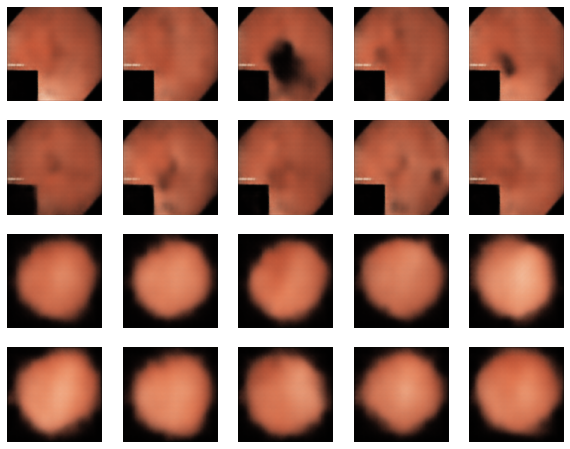

In [5]:
prototype_images = protovae.get_prototype_images()


prototype_images = prototype_images * 0.5 + 0.5

fig = plt.figure(figsize=(10, 8))
for i in range(protovae.num_prototypes):
    ax = fig.add_subplot(4, 5, i + 1)
    ax.imshow(prototype_images[i].detach().numpy().transpose(1,2,0), cmap='gray')
    ax.axis('off')
plt.show()

## Producing Explanations

#### Make a Prediction with the Segmentation Model

/Users/abdu/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/transforms/functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525682339/work/torch/csrc/utils/tensor_numpy.cpp:205.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


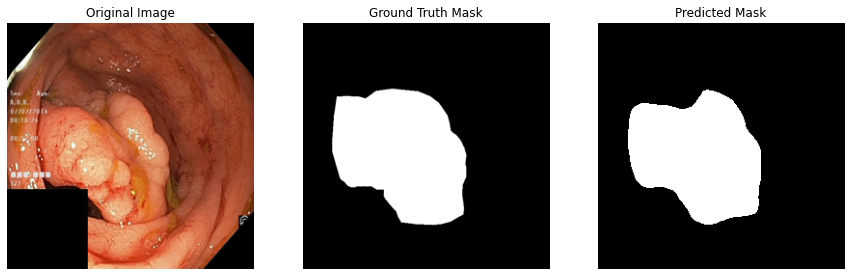

In [6]:
# Select a random image from the test set and make a prediction
i = random.choice([14,4,9,22,36,1,25])
model.eval()
pred = model(model.test_dataset[i][0].unsqueeze(0).to(device))
pred = pred.squeeze(0).squeeze(0).detach().numpy()
pred = np.where(pred > 0.5, 1, 0)

# plot the original image, the ground truth mask and the predicted mask
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(model.test_dataset[i][0].permute(1,2,0).cpu().numpy())
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(model.test_dataset[i][1].squeeze(0), cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')
ax[2].imshow(pred, cmap='gray')
ax[2].set_title("Predicted Mask")
ax[2].axis('off')
plt.show()



#### Mask out the Polyp and the Background

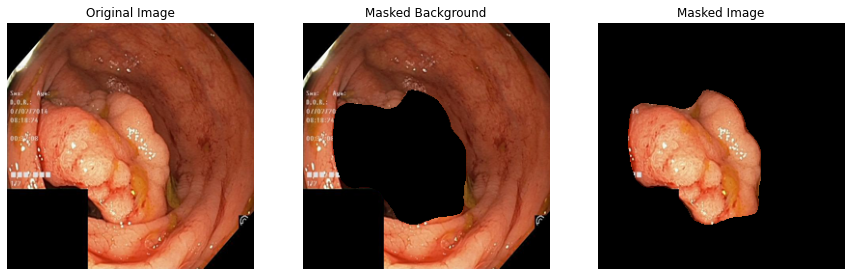

In [7]:
# mask out the background of the original image using the predicted mask
masked_image = model.test_dataset[i][0].permute(1,2,0).cpu().numpy()
masked_image[pred == 0] = 0

masked_bg = model.test_dataset[i][0].permute(1,2,0).cpu().numpy()
masked_bg[pred == 1] = 0

# plot the original image, the predicted mask and the masked image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(model.test_dataset[i][0].permute(1,2,0).cpu().numpy())
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(masked_bg, cmap='gray')
ax[1].set_title("Masked Background")
ax[1].axis('off')
ax[2].imshow(masked_image)
ax[2].set_title("Masked Image")
ax[2].axis('off')
plt.show()

#### Produce Explanations for the Polyp and the Background

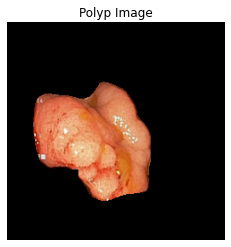

The predicted class is: 1


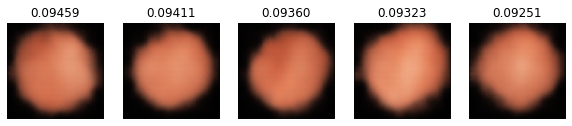

In [8]:
# Produce explanation for the Polyp image
masked_image = torch.from_numpy(masked_image).permute(2,0,1).unsqueeze(0).to(device)

# normalize the masked image
masked_image = (masked_image - 0.5) / 0.5

with torch.no_grad():
    output, decoded, kl_loss, orth_loss,sim_scores = protovae(masked_image, torch.tensor([1]).to(device), False)

# reverse the normalization with mean = (0.5, 0.5, 0.5) and std = (0.5, 0.5, 0.5)
masked_image = masked_image * 0.5 + 0.5

# plot the original image
plt.imshow(masked_image[0].cpu().numpy().transpose(1,2,0))
plt.axis('off')
plt.title("Polyp Image")
plt.show()

print(f"The predicted class is: {torch.argmax(output[0])}")

# Find the similarity scores of the input image with the prototypes
sim_scores = sim_scores[0].cpu().numpy()

# Plot the top 5 prototypes with the highest similarity scores from the most similar to the least similar
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    ax[i].imshow(prototype_images[np.argsort(sim_scores)[-5:][4 - i]].detach().numpy().transpose(1,2,0))
    # put the similarity score as the title of the image
    ax[i].set_title(f"{sim_scores[np.argsort(sim_scores)[-5:][4 - i]]:.5f}")
    ax[i].axis('off')
plt.show()


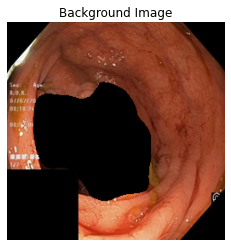

The predicted class is: 0


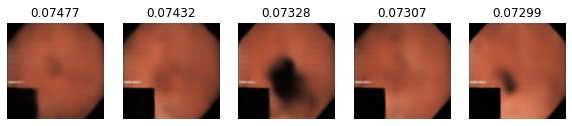

In [9]:
 # Produce explanations for the Background image
masked_bg = torch.from_numpy(masked_bg).permute(2,0,1).unsqueeze(0).to(device)

# normalize the masked image
masked_bg = (masked_bg - 0.5) / 0.5

with torch.no_grad():
    output, decoded, kl_loss, orth_loss,sim_scores = protovae(masked_bg, torch.tensor([0]).to(device), False)


masked_bg = masked_bg * 0.5 + 0.5


plt.imshow(masked_bg[0].cpu().numpy().transpose(1,2,0))
plt.axis('off')
plt.title("Background Image")
plt.show()

print(f"The predicted class is: {torch.argmax(output[0])}")


sim_scores = sim_scores[0].cpu().numpy()


fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    ax[i].imshow(prototype_images[np.argsort(sim_scores)[-5:][4 - i]].detach().numpy().transpose(1,2,0))
    # put the similarity score as the title of the image
    ax[i].set_title(f"{sim_scores[np.argsort(sim_scores)[-5:][4 - i]]:.5f}")
    ax[i].axis('off')
plt.show()

